<a target="_blank" href="https://colab.research.google.com/github/arindamchoudhury/ml-projects/blob/main/MNIST_Handwritten_Digits.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Introduction

In this project, we will build a neural network of to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)



## Imports

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import multiprocessing

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Load the Dataset

In [16]:
# Define transforms
# https://nextjournal.com/gkoehler/pytorch-mnist Normalize params 
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,))
            ])

# Create training set and define training dataloader
training_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="data", train=False, download=True, transform=transform)

## Let's keep 80% of the training data for training
train_len = int(len(training_dataset) * 0.8)

## Let's use the remaining for validation
val_len = len(training_dataset) - train_len

train_dataset, valid_dataset = torch.utils.data.random_split(training_dataset, [train_len, val_len])

# Create test set and define test dataloader
batch_size = 64
num_workers = multiprocessing.cpu_count()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

## Explore the Dataset


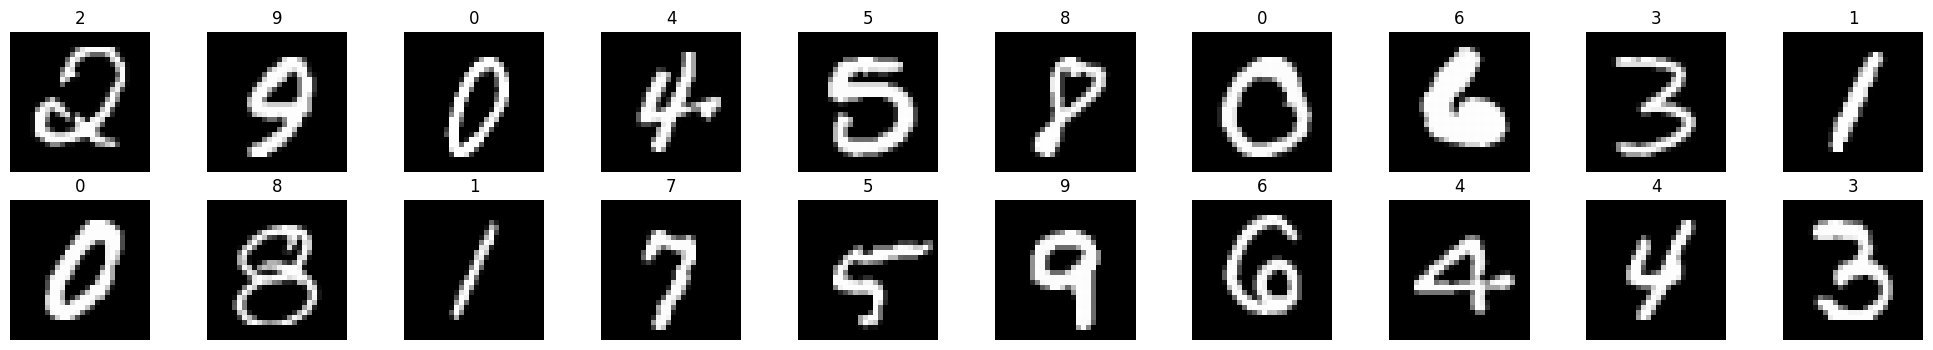

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig, subs = plt.subplots(2, 10, figsize=(25, 4))
for idx, sub in zip(np.arange(20), subs.flatten()):
    sub.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    sub.set_title(str(labels[idx].item()))
    sub.axis("off")

## Build the Model

In [19]:
# base of the LeNet5 collected from https://github.com/rgkannan676/MNIST-Handwritten-Digit-Recognition/blob/main/OptmizerSelection.py
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.conv1_bn = nn.BatchNorm2d(6)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        torch.nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.relu3 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(120)
        
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        torch.nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        self.relu4 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(84)
        
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        torch.nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')        

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv1_bn(out)
        out = self.relu1(out)
        out = self.pool1(out)
        
        out = self.conv2(out)
        out = self.conv2_bn(out)
        out = self.relu2(out)
        out = self.pool2(out)

        out = out.view(-1,16*5*5)

        out = self.fc1(out)
        out = self.relu3(out)
        out = self.bn1(out)

        out = self.fc2(out)
        out = self.relu4(out)
        out = self.bn2(out)

        out = self.fc3(out)
        return out
    
net = LeNet5()
net.to(device)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1_bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (relu3): ReLU()
  (bn1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU()
  (bn2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu5): ReLU()
)

In [20]:
scripted = torch.jit.script(net)
torch.jit.save(scripted, "visualize_model.pt")
# open in neutron.app to visualize the model

## Running the Model

In [21]:
def accuracy(logits, labels):
    _, yhat = torch.max(logits.data, dim=1)
    equals = yhat == labels
    return torch.mean(equals.type(torch.FloatTensor))

In [31]:
# collected from https://www.coursera.org/projects/pneumonia-classification-using-pytorch
class ModelTrainer():
    def __init__(self, criterion = None, optimizer = None):        
        self.criterion = criterion
        self.optimizer = optimizer
  
    def train_batch_loop(self, model, trainloader):        
        train_loss = 0.0
        train_acc = 0.0
        
        for data, labels in tqdm(trainloader, desc="Training", total=len(train_loader), leave=True):            
            data = data.to(device)
            labels = labels.to(device)
            
            self.optimizer.zero_grad()
            logits = model(data)
            loss = self.criterion(logits, labels)
                        
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item() * data.size(0)
            train_acc += accuracy(logits, labels)
            
        return train_loss / len(trainloader.dataset), train_acc / len(trainloader) 

    
    def valid_batch_loop(self, model, validloader):        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for data, labels in tqdm(validloader, desc="Validating", total=len(validloader), leave=True):                
            data = data.to(device)
            labels = labels.to(device)
             
            logits = model(data)
            loss = self.criterion(logits, labels)
              
            valid_loss += loss.item() * data.size(0)
            valid_acc += accuracy(logits, labels)
            
        return valid_loss / len(validloader.dataset), valid_acc / len(validloader)
    
    def test_batch_loop(self, model, testloader):
        test_loss = 0.0
        test_acc = 0.0
        class_correct = list(0.0 for i in range(10))
        class_total = list(0.0 for i in range(10))

        for data, labels in tqdm(testloader, desc="Testing", total=len(testloader), leave=True):                
            data = data.to(device)
            labels = labels.to(device)
             
            logits = model(data)
            loss = self.criterion(logits, labels)

            _, preds = torch.max(logits, dim=1)
            correct = np.squeeze(preds.eq(labels.data.view_as(preds)))

            for i in range(data.shape[0]):
                label = labels.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

              
            test_loss += loss.item() * data.size(0)
            test_acc += accuracy(logits, labels)
            
        return test_loss / len(testloader.dataset), test_acc / len(testloader), class_correct, class_total

            
        
    def fit(self, model, trainloader, validloader, epochs, filename):        
        valid_min_loss = np.Inf
        train_loss_history = list()
        valid_loss_history = list()
        
        for i in range(epochs):            
            model.train()
            avg_train_loss, avg_train_acc = self.train_batch_loop(model, trainloader)
            train_loss_history.append(avg_train_loss)
            
            with torch.no_grad():
                model.eval()
                avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model, validloader)
                valid_loss_history.append(avg_valid_loss)
            
            if avg_valid_loss < valid_min_loss:
                print(f"validation loss decreased {valid_min_loss:.6f} --> {avg_valid_loss:.6f}")
                torch.save(model.state_dict(), filename)
                valid_min_loss = avg_valid_loss

                
            print(f"Epoch : {i+1} Train Loss : {avg_train_loss:.6f} Train Acc : {avg_train_acc:.6f}")
            print(f"Epoch : {i+1} Valid Loss : {avg_valid_loss:.6f} Valid Acc : {avg_valid_acc:.6f} Min Loss : {valid_min_loss:.6f}")
        
        return train_loss_history, valid_loss_history

In [32]:
optimizer =  optim.Adam(net.parameters(), lr=0.003, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

trainer = ModelTrainer(criterion, optimizer)
train_loss_history, valid_loss_history = trainer.fit(model=net, trainloader=train_loader, validloader=valid_loader, epochs=20, filename="leNet.pt")

Plot the training loss and validation loss/accuracy:

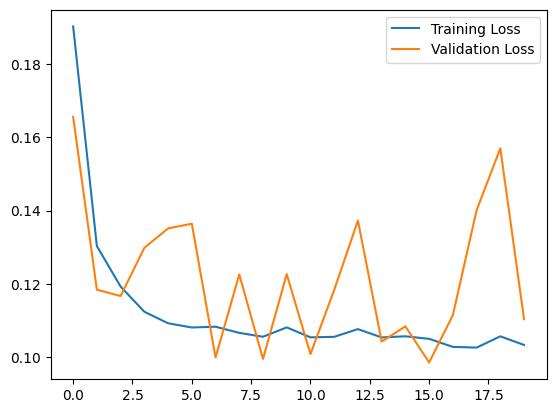

In [24]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(valid_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing the model


In [34]:
test_net = LeNet5()
test_net.to(device)
test_net.load_state_dict(torch.load('leNet.pt'))

with torch.no_grad():
    test_net.eval()
    avg_test_loss, avg_test_acc, class_correct, class_total = trainer.test_batch_loop(test_net, test_loader)

print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

for i in range(10):
    if class_total[i] > 0:
        print(f"Test Accuracy of {i}: {100*class_correct[i]/class_total[i]:.2f} ({int(np.sum(class_correct[i]))}/{int(np.sum(class_total[i]))})")
    else:
        print(f"Test Accuracy of {i}: NA (no training examples)")

print(f"Test Accuracy (Overall): {100*np.sum(class_correct)/np.sum(class_total)}) ({int(np.sum(class_correct))}/{int(np.sum(class_total))})")



Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss : 0.09425202797651291
Test Acc : 0.9791998267173767
Test Accuracy-- of 0: 99.80 (978/980)
Test Accuracy-- of 1: 99.82 (1133/1135)
Test Accuracy-- of 2: 96.32 (994/1032)
Test Accuracy-- of 3: 98.32 (993/1010)
Test Accuracy-- of 4: 95.82 (941/982)
Test Accuracy-- of 5: 98.09 (875/892)
Test Accuracy-- of 6: 95.72 (917/958)
Test Accuracy-- of 7: 98.44 (1012/1028)
Test Accuracy-- of 8: 98.25 (957/974)
Test Accuracy-- of 9: 98.22 (991/1009)
Test Accuracy (Overall): 97.91) (9791/10000)


## Saving model

In [ ]:
torch.save(net.state_dict(), "LeNetFinal.pt")